In [64]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [52]:
BASE_PATH = "D:\\bone_fracture_detection\\archive\\Bone_Fracture_Binary_Classification\\Bone_Fracture_Binary_Classification\\train"
categories_class = ["fractured", "not_fractured"]

image_paths = []
labels = []

In [3]:
for category in categories_class:
    category_path = os.path.join(BASE_PATH, category)
    # print(category_path)

    for image_name in os.listdir(category_path):
        # print(image_name)
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

In [4]:
df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

print(df.head())
print(df.tail())
print("-"*80)
print(f"Columns: {df.columns}")
print(f"row, column: {df.shape}")
print("-"*80)
print(f"Info: {df.info()}")
print("-"*80)
print(df['label'].value_counts())

                                          image_path      label
0  D:\bone_fracture_detection\archive\Bone_Fractu...  fractured
1  D:\bone_fracture_detection\archive\Bone_Fractu...  fractured
2  D:\bone_fracture_detection\archive\Bone_Fractu...  fractured
3  D:\bone_fracture_detection\archive\Bone_Fractu...  fractured
4  D:\bone_fracture_detection\archive\Bone_Fractu...  fractured
                                             image_path          label
9241  D:\bone_fracture_detection\archive\Bone_Fractu...  not_fractured
9242  D:\bone_fracture_detection\archive\Bone_Fractu...  not_fractured
9243  D:\bone_fracture_detection\archive\Bone_Fractu...  not_fractured
9244  D:\bone_fracture_detection\archive\Bone_Fractu...  not_fractured
9245  D:\bone_fracture_detection\archive\Bone_Fractu...  not_fractured
--------------------------------------------------------------------------------
Columns: Index(['image_path', 'label'], dtype='object')
row, column: (9246, 2)
------------------------------

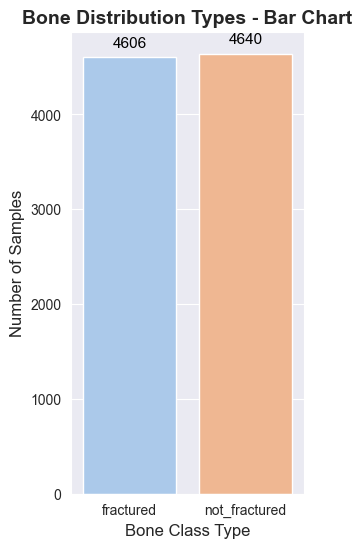

In [58]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(3, 6)) # width, height
sns.countplot(data=df, x='label', palette="pastel", hue="label", ax=ax)

ax.set_title("Bone Distribution Types - Bar Chart", fontsize=14, fontweight='bold')
ax.set_xlabel("Bone Class Type", fontsize=12)
ax.set_ylabel("Number of Samples", fontsize=12)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = "center", va = "bottom", fontsize=11, color='black',
                xytext=(0, 5), textcoords = 'offset points')
plt.show()

label
not_fractured    4640
fractured        4606
Name: count, dtype: int64


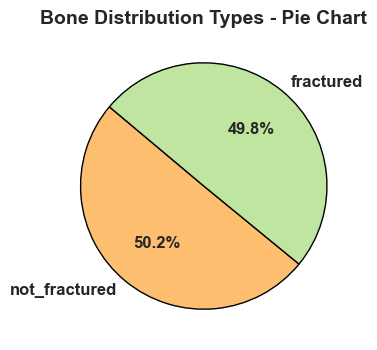

In [48]:
label_counts = df["label"].value_counts()
print(label_counts)

fig, ax = plt.subplots(figsize=(4, 4))
colors = sns.color_palette("Spectral", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 12, 'weight': 'bold'}, wedgeprops={'edgecolor': 'black', 'linewidth': 1})
ax.set_title("Bone Distribution Types - Pie Chart", fontsize=14, fontweight='bold')

plt.show()

0 fractured
0    D:\bone_fracture_detection\archive\Bone_Fractu...
1    D:\bone_fracture_detection\archive\Bone_Fractu...
2    D:\bone_fracture_detection\archive\Bone_Fractu...
3    D:\bone_fracture_detection\archive\Bone_Fractu...
4    D:\bone_fracture_detection\archive\Bone_Fractu...
Name: image_path, dtype: object
1 not_fractured
4606    D:\bone_fracture_detection\archive\Bone_Fractu...
4607    D:\bone_fracture_detection\archive\Bone_Fractu...
4608    D:\bone_fracture_detection\archive\Bone_Fractu...
4609    D:\bone_fracture_detection\archive\Bone_Fractu...
4610    D:\bone_fracture_detection\archive\Bone_Fractu...
Name: image_path, dtype: object


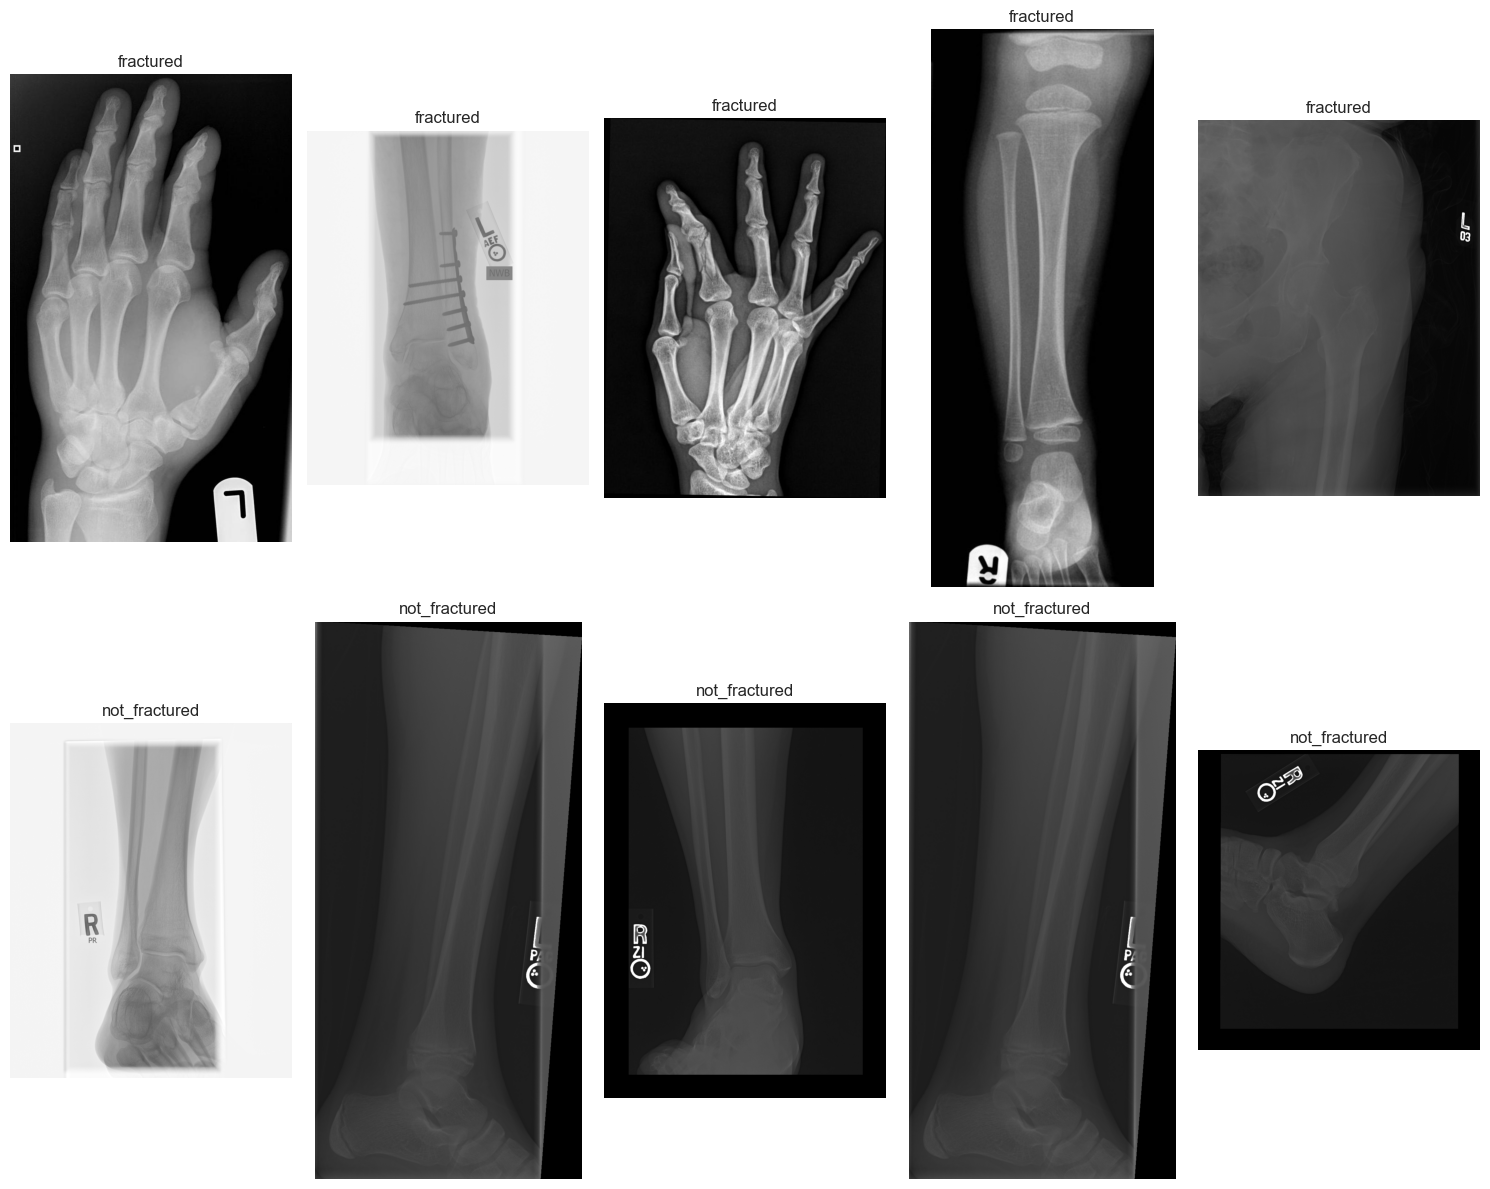

In [56]:
plt.figure(figsize=(15, 12))
for i, category in enumerate(categories_class):
    print(i, category)
    category_images = df[df['label'] == category]['image_path'].iloc[:5]

    print(category_images)
    for j, img_path in enumerate(category_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories_class), 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [67]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
train_df, val_df = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state=42)

In [94]:
class FractureDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.label_map = {'fractured': 1, 'not_fractured': 0}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        label = self.label_map[row['label']]
        if self.transform:
            img = self.transform(img)

        return img, label

In [95]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [96]:
train_dataset = FractureDataset(train_df, transform)
val_dataset = FractureDataset(val_df, transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

model = torchvision.models.resnet18(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.cpu()

In [97]:
def synflow_pruning(model, sparsity=0.95, iters=100):
    model.train()
    for p in model.parameters():
        if p.dim() > 1:
            p.data = torch.abs(p.data)

    dummy = torch.randn(1, 3, 224, 224).cpu()
    for _ in range(iters):
        out = model(dummy)
        loss = out.sum()
        model.zero_grad()
        loss.backward()

        for p in model.parameters():
            if p.grad is not None and p.dim() > 1:
                p.data = p.data * torch.abs(p.grad)

        scores = {}
        for n, p in model.named_parameters():
            if p.dim() > 1:
                scores[n] = p.data.abs().flatten()

        total = sum(s.numel() for s in scores.values())
        thr = torch.topk(torch.cat([s for s in scores.values()]), int(total * sparsity), largest=False)[0].max()
        for n, p in model.named_parameters():
            if p.dim() > 1:
                mask = (p.data.abs() >= thr).float()
                p.data *= mask

        return model

In [99]:
model = synflow_pruning(model, sparsity = 0.95)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_accs = []
best_acc = 0.0
patience = 3
wait = 0

for epoch in range(30):
    model.train()
    epoch_loss = 0.0
    for X, y in train_loader:
        X, y = X.cpu(), y.cpu()
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss/len(train_loader))

    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in val_loader:
            pred = model(X.cpu()).argmax(1)
            correct += (pred == y.cpu()).sum().item()
    acc = correct / len(val_dataset)
    val_accs.append(acc)
    print(f"Epoch {epoch + 1:02d} | Loss: {train_losses[-1]:.4f} | Val Acc: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_fracture_model.pth')
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

model.load_state_dict(torch.load('best_fracture_model.pth'))

Epoch 01 | Loss: 0.4792 | Val Acc: 0.6368
Epoch 02 | Loss: 0.3170 | Val Acc: 0.6308
Epoch 03 | Loss: 0.2209 | Val Acc: 0.7319
Epoch 04 | Loss: 0.1797 | Val Acc: 0.6719
Epoch 05 | Loss: 0.1403 | Val Acc: 0.6784
Epoch 06 | Loss: 0.1236 | Val Acc: 0.8632
Epoch 07 | Loss: 0.0826 | Val Acc: 0.9184
Epoch 08 | Loss: 0.0885 | Val Acc: 0.7951
Epoch 09 | Loss: 0.0761 | Val Acc: 0.9741
Epoch 10 | Loss: 0.0510 | Val Acc: 0.8492
Epoch 11 | Loss: 0.0377 | Val Acc: 0.9481
Epoch 12 | Loss: 0.0404 | Val Acc: 0.9097
Early stopping triggered at epoch 12


<All keys matched successfully>

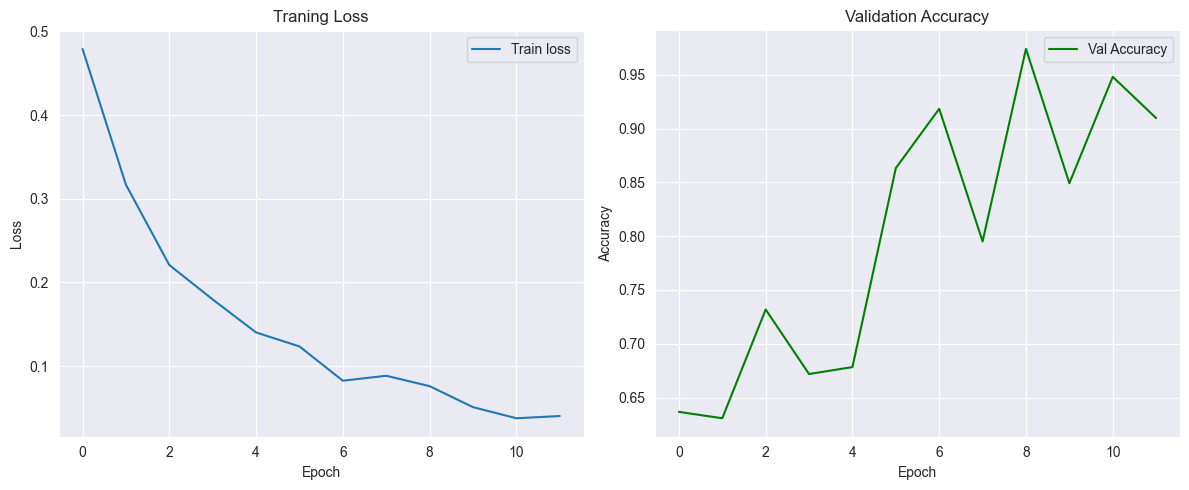

In [101]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Traning Loss')
plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.tight_layout()
plt.savefig('curves.png')
plt.show()

In [103]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        pred = model(X.cpu()).argmax(1).cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=['not_fractured', 'fractured']))


=== Classification Report ===
               precision    recall  f1-score   support

not_fractured       0.97      0.98      0.97       928
    fractured       0.98      0.97      0.97       922

     accuracy                           0.97      1850
    macro avg       0.97      0.97      0.97      1850
 weighted avg       0.97      0.97      0.97      1850



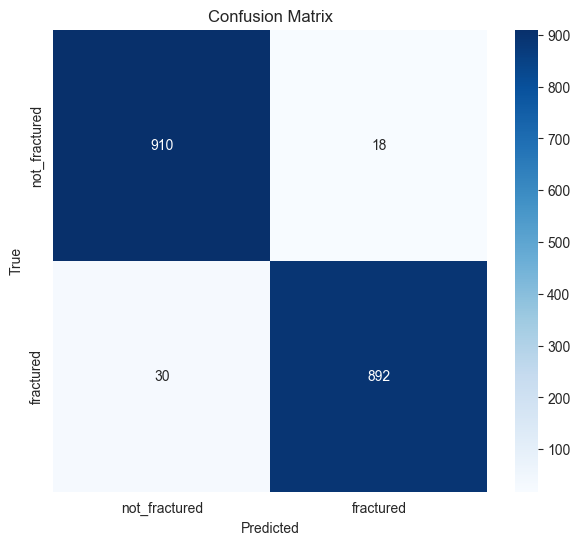

In [104]:
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['not_fractured', 'fractured'], yticklabels=['not_fractured', 'fractured'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [105]:
final_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nFinal Val Accuracy: {final_acc:.4f}")
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Remaning parameters: {total_params:,} ({total_params/11_689_512*100:.1f}% of original)")

torch.save(model.state_dict(), 'fracture_detector_final.pth')


Final Val Accuracy: 0.9741
Remaning parameters: 11,177,538 (95.6% of original)
